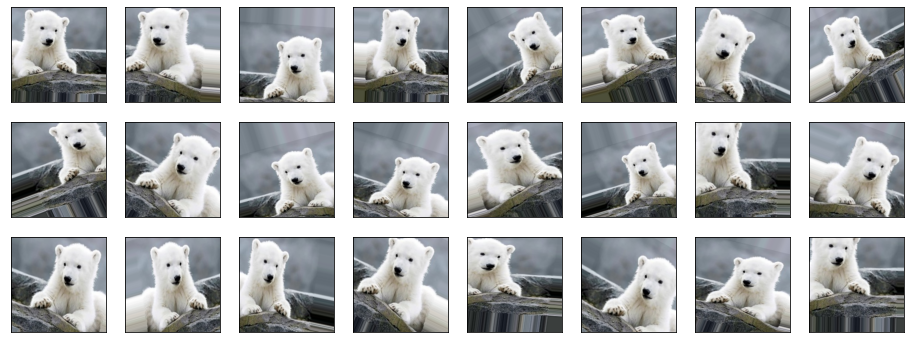

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
 
# Load an image
x = image.load_img('Wildlife/train/polar_bear/polar_bear_010.jpeg')
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
 
# Wrap an ImageDataGenerator around it
idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         rotation_range=30,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2)
idg.fit(x)
 
# Generate 24 versions of the image
generator = idg.flow(x, [0], batch_size=1, seed=0)
fig, axes = plt.subplots(3, 8, figsize=(16, 6),
                         subplot_kw={'xticks': [], 'yticks': []})
 
for i, ax in enumerate(axes.flat):
    img, label = generator.next()
    ax.imshow(img[0])